# Dynes fit in SIS Tunneljunction

In [3]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.baseclass import BaseClass
from utilities.baseevaluation import BaseEvaluation
from utilities.baseplot import BasePlot
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.baseclass"])
importlib.reload(sys.modules["utilities.baseevaluation"])
importlib.reload(sys.modules["utilities.baseplot"])
importlib.reload(sys.modules["utilities.ivevaluation"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

importlib.reload(logging)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s")
# pip install numpy matplotlib scipy tqdm torch hdf5view h5py PySide6


import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

In [87]:
# Constants
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

k_B = 1.381e-23     # Boltzmann constant (J/K)

V_gap = 189e-6      # V
Delta = V_gap*e     # V * A * s
nu = 15e9           # 1 / s
pincode = np.array([0.05]) # 0.05 G0

# Exp Data 0.05 $G_0$

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) ... BaseClass initialized.
(base plot) ... BasePlot initialized.
(iv plot) ... IVPlot initialized.
(base) Amplitude Study (0.05G0, 15GHz, Stripline)
(base) loadData()
(iv plot) smoothing = True
(iv plot) window_length = 20
(base plot) saveFigure()
(base plot) saveFigure()


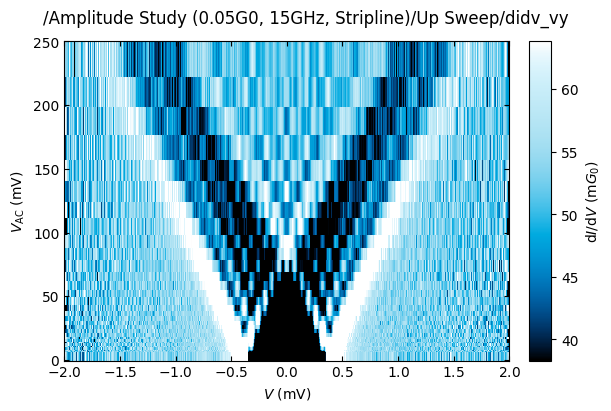

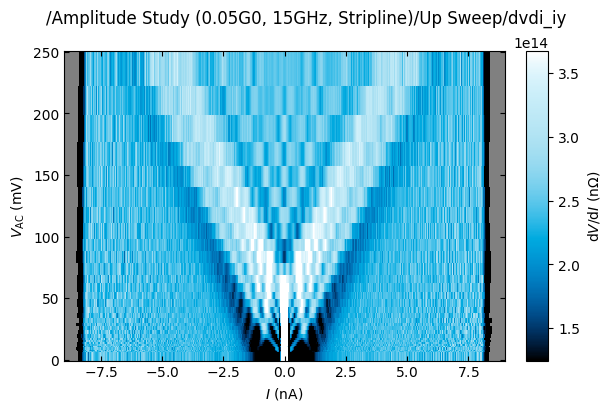

In [88]:
# get exp data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])

eva = IVPlot()
eva.file_directory = '/Volumes/speedyboy/measurement data 2/'
eva.file_folder = '2023-10-27_HIV_tunnel_contact/'
eva.file_name = '2023-10-27_HIV_tunnel_contact_1.hdf5'
eva.setAmplifications(1000, 10000)
eva.setV(2e-3, voltage_bins=1000)
eva.setI(9e-9, current_bins=1000)
eva.setA(0, 0.25, 250)
eva.downsample_frequency = 43

# Amplitude Study (0.05G0, 15GHz, Stripline)
eva.title = "Amplitude Study (0.05G0, 15GHz, Stripline)"
eva.sub_folder = ""
eva.data_folder = "exp_data"

# eva.setMeasurement("frequency_at_15GHz")
# eva.setKeys(index_0=3, index_1=-3, norm=1)
# eva.showKeys()
# eva.addKey('nu=-31.0dBm', -1000)
# eva.up_sweep, = eva.getMaps([1])
# eva.up_sweep, = eva.getMapsAmplitude([eva.up_sweep])
# eva.y_axis = eva.amplitude_axis
# eva.saveData()

eva.loadData()
eva.figure_folder = "exp_data"
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$V_\mathrm{AC}$", "V"]
eva.smoothing = True
eva.window_length = 20
eva.plot_T = False
eva.plot_all()


In [89]:

I_exp = eva.up_sweep['current']*h/(2*e*Delta)

dIdV_exp = eva.up_sweep["differential_conductance"]
V_bias_exp = eva.mapped["voltage_axis"]
V_AC = eva.mapped["amplitude_axis"]

I_0_exp = I_exp[0,:]
dIdV_0_exp = dIdV_exp[0, :]
V_0_exp = np.linspace(-5.99, 5.99, 1199, dtype='float64')

V = V_bias_exp
I = I_0_exp
dIdV = dIdV_0_exp

In [118]:
import numpy as np
from scipy.constants import k, e, h
from scipy.integrate import simpson

def fermi(E, T):
    """Fermi-Dirac distribution"""
    return 1 / (np.exp(E / (k * T)) + 1)

def dynes_dos(E, Delta, Gamma):
    """Dynes density of states (normalized to N₀)"""
    return np.real((E - 1j * Gamma) / np.sqrt((E - 1j * Gamma)**2 - Delta**2))

def dynes_dos(E, Delta, Gamma):
    """Dynes density of states (normalized to N₀)"""
    return np.real((E) / np.sqrt((E)**2 - Delta**2))

def tunneling_current(V, T, Delta, Gamma, R_N, E_max=5e-3, N=1000):
    """
    Tunneling current for an S–S or S–N junction using the Dynes model.
    
    Parameters
    ----------
    V : float or ndarray
        Voltage in V
    T : float
        Temperature in K
    Delta : float
        Superconducting gap in eV
    Gamma : float
        Dynes broadening parameter in eV
    R_N : float
        Normal-state resistance in Ohm
    E_max : float
        Integration energy limit in eV
    N : int
        Number of energy steps
    
    Returns
    -------
    I : float or ndarray
        Current in A
    """
    E = np.linspace(-E_max, E_max, N)  # Energy axis in eV
    dE = E[1] - E[0]

    # Convert energies to Joules for Fermi function
    E_J = E * e

    def integrand(E, V_applied):
        E_shifted = E + V_applied  # in eV
        dos1 = dynes_dos(E, Delta, Gamma)
        dos2 = dynes_dos(E_shifted, Delta, Gamma)
        f_diff = fermi(E_J, T) - fermi((E_shifted)*e, T)
        return dos1 * dos2 * f_diff

    # Handle scalar or array input for V
    V = np.atleast_1d(V)
    I = []
    for V_i in V:
        integrand_vals = integrand(E, V_i)
        I_V = (1 / (e * R_N)) * simpson(integrand_vals, E_J)  # A
        I.append(I_V)

    return np.array(I) if len(I) > 1 else I[0]

from scipy.optimize import curve_fit

def model(V, Delta, Gamma, T, R_N):
    return tunneling_current(V, T=T, Delta=Delta, Gamma=Gamma, R_N=R_N)

# Example data

# Initial parameter guess: [Delta (eV), Gamma (eV), T (K), R_N (Ohm)]
p0 = [189e-6, 2e-6, 0.1, 258e3]
bounds=([150e-6, 20e-9, 0.01, 200e3], [250e-6, 2e-6, 1, 300e3])

popt, pcov = curve_fit(model, V, I, p0=p0, bounds=bounds)

# Plot result
plt.plot(V * 1e6, I, label='Measured')  # µV on x-axis
plt.plot(V * 1e6, model(V, *popt), label='Fit', lw=2)
plt.xlabel("Bias Voltage (µV)")
plt.ylabel("I (A)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {popt[0]*1e6:.1f} µeV")
print(f"Gamma = {popt[1]*1e6:.2f} µeV")
print(f"T     = {popt[2]:.3f} K")
print(f"Scale = {popt[3]*1e-3:.3f} kOhm")
# print(f"Offset = {popt[4]:.3f}")

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_14173/2432148542.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.real((E) / np.sqrt((E)**2 - Delta**2))
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_14173/2432148542.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (np.exp(E / (k * T)) + 1)


ValueError: Residuals are not finite in the initial point.

	•	The energy axis E is integrated numerically.
	•	For SIS junctions, you’d need to convolve two DOS functions:

$$ I(V) \propto \int N_s(E) N_s(E + eV)[f(E) - f(E + eV)] \, dE $$
This requires a 2D integral (slower but more realistic).

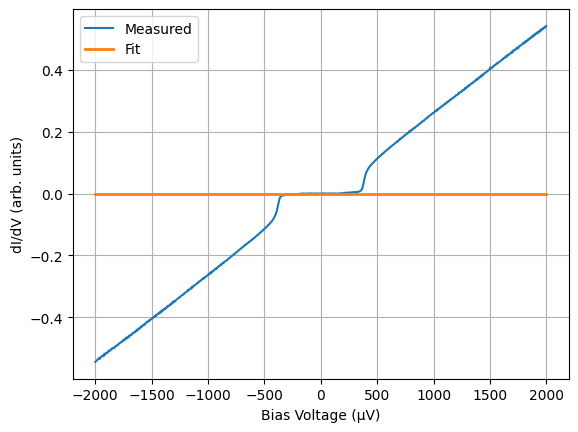

Fitted parameters:
Delta = 0.0 µeV
Gamma = 0.00 µeV
T     = 1.000 K
Scale = 515998.722


In [100]:
import numpy as np

def tunneling_current(V_array, Delta, Gamma, T, R_N):
    """
    Computes the tunneling current for a symmetric superconductor–superconductor (S–S) junction
    using the Dynes density of states, over an array of voltages V_array.
    
    Parameters
    ----------
    V_array : array_like
        Array of bias voltages (in Volts).
    Delta : float
        Superconducting gap (in Joules).
    Gamma : float
        Broadening parameter (in Joules).
    T : float
        Temperature (in Kelvin).
    R_N : float
        Normal resistance of the junction (in Ohms).
    
    Returns
    -------
    I_array : ndarray
        Tunneling current for each bias voltage.
    """
    e = 1.602e-19       # Charge of electron (C)
    k_B = 1.381e-23     # Boltzmann constant (J/K)
    E = np.linspace(-5 * Delta, 5 * Delta, 1000)

    def f(E):  # Fermi-Dirac distribution
        return 1 / (np.exp(E / (k_B * T)) + 1)

    def N(E):  # Dynes density of states
        z = E + 1j * Gamma
        return np.real(z / np.sqrt(z**2 - Delta**2))

    N_E = N(E)
    f_E = f(E)

    I_array = []
    for V in V_array:
        E_shifted = E + e * V
        N_Ep = N(E_shifted)
        f_Ep = f(E_shifted)
        integrand = N_E * N_Ep * (f_E - f_Ep)
        I = np.trapezoid(integrand, E) / (e * R_N)
        I_array.append(I)

    return np.array(I_array)

from scipy.optimize import curve_fit

# Wrap the model so it can be used by curve_fit (expects first arg = x)
def model_function(V, Delta, Gamma, T, R_N):
    return tunneling_current(V, Delta, Gamma, T, R_N)

# Example usage
# V_meas, I_meas = your measured data arrays
# initial_guesses = [Delta0, Gamma0, T0, R_N0] (in SI units: Joule, Joule, K, Ohm)

params, covariance = curve_fit(model_function, V, I,
                               p0=[1.76 * k_B * 1.2, 1e-5 * k_B * 1.2, 1.2, 10],
                               bounds=([0, 0, 0.01, 0.1], [1e-20, 1e-20, 10, 1e3]))
Delta_fit, Gamma_fit, T_fit, R_N_fit = params


# Plot result
plt.plot(V * 1e6, I, label='Measured')  # µV on x-axis
plt.plot(V * 1e6, tunneling_current(V, *popt), label='Fit', lw=2)
plt.xlabel("Bias Voltage (µV)")
plt.ylabel("dI/dV (arb. units)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {popt[0]*1e6:.1f} µeV")
print(f"Gamma = {popt[1]*1e6:.2f} µeV")
print(f"T     = {popt[2]:.3f} K")
# print(f"Scale = {popt[3]:.3f}")
# print(f"Offset = {popt[4]:.3f}")

In [77]:

from scipy.signal import savgol_filter

dIdV_smooth = savgol_filter(
        dIdV,
        window_length=20,
        polyorder=2,
    )

# dIdV_smooth /= 0.05

In [86]:
# Constants
kB = 8.617333e-5  # eV/K

import numpy as np
from scipy.integrate import quad
from scipy.constants import k, e
from scipy.optimize import curve_fit

def fermi(E, T):
    return 1 / (np.exp(E / (k * T)) + 1)

def dynes_dos(E, Delta, Gamma):
    return np.real((E + 1j * Gamma) / np.sqrt((E + 1j * Gamma)**2 - Delta**2))

def tunneling_current(V, Delta, Gamma, T, R_N):
    e = 1.602e-19       # Charge of electron (Coulombs)
    k_B = 1.381e-23     # Boltzmann constant (J/K)
    
    # Energy grid — consistent size
    E = np.linspace(-5 * Delta, 5 * Delta, 1000)
    
    def f(E):  # Fermi-Dirac distribution
        return 1 / (np.exp(E / (k_B * T)) + 1)

    def N(E):  # Dynes density of states
        z = E + 1j * Gamma
        return np.real(z / np.sqrt(z**2 - Delta**2))

    # Evaluate functions on E and E + eV
    E_shifted = E + e * V

    # Ensure all arrays have shape (1000,)
    integrand = N(E) * N(E_shifted) * (f(E) - f(E_shifted))

    # Numerically integrate
    I = np.trapezoid(integrand, E) / (e * R_N)
    return I


popt, _ = curve_fit(tunneling_current, V, I, p0=[189e-6, 10e-6, .1, 1/(.05*G_0)])

# Plot result
plt.plot(V * 1e6, I, label='Measured')  # µV on x-axis
plt.plot(V * 1e6, tunneling_current(V, *popt), label='Fit', lw=2)
plt.xlabel("Bias Voltage (µV)")
plt.ylabel("dI/dV (arb. units)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Fitted parameters:")
print(f"Delta = {popt[0]*1e6:.1f} µeV")
print(f"Gamma = {popt[1]*1e6:.2f} µeV")
print(f"T     = {popt[2]:.3f} K")
# print(f"Scale = {popt[3]:.3f}")
# print(f"Offset = {popt[4]:.3f}")

ValueError: operands could not be broadcast together with shapes (1000,) (1001,) 

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_14173/2126327985.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lambda V, Delta, T, scale, offset:


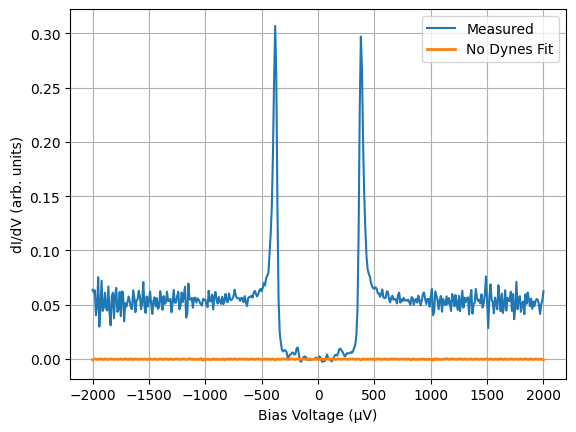

In [45]:
def bcs_DOS(E, Delta):
    E = np.array(E)
    dos = np.zeros_like(E)
    mask = np.abs(E) > Delta
    dos[mask] = np.abs(E[mask]) / np.sqrt(E[mask]**2 - Delta**2)
    return dos

def SIS_current_no_dynes(V, Delta, T, scale, offset):
    E = np.linspace(-5*Delta, 5*Delta, 2000)
    Ns = bcs_DOS(E, Delta)
    I = np.zeros_like(V)
    for i, v in enumerate(V):
        Ep = E + v
        Ns2 = bcs_DOS(Ep, Delta)
        fe = f(E, T)
        fe_p = f(Ep, T)
        integrand = Ns * Ns2 * (fe - fe_p)
        I[i] = np.trapezoid(integrand, E)
    return scale * I + offset

def SIS_dIdV_no_dynes(V, Delta, T, scale, offset):
    I = SIS_current_no_dynes(V, Delta, T, scale, offset)
    dV = V[1] - V[0]
    return np.gradient(I, dV)

# Initial guess: Delta in eV, T in K
p0 = [189e-6, 0.1, 1.0, 0.0]  # Delta, T, scale, offset

# Fit
popt, _ = curve_fit(lambda V, Delta, T, scale, offset:
                    SIS_dIdV_no_dynes(V, Delta, T, scale, offset),
                    V_bias_exp, dIdV_0_exp, p0=p0)

# Plot
plt.plot(V_bias_exp * 1e6, dIdV_0_exp, label="Measured")
plt.plot(V_bias_exp * 1e6, SIS_dIdV_no_dynes(V_bias_exp, *popt), label="No Dynes Fit", lw=2)
plt.xlabel("Bias Voltage (µV)")
plt.ylabel("dI/dV (arb. units)")
plt.legend()
plt.grid()
plt.show()

In [46]:
dIdV

array([ 6.38193310e-02,  6.14697504e-02,  6.32227532e-02,  4.03542944e-02,
        4.90808357e-02,  7.53370653e-02,  2.97690558e-02,  4.74294696e-02,
        7.20200371e-02,  4.42555026e-02,  4.77421324e-02,  6.10120104e-02,
        4.65047504e-02,  4.47002649e-02,  6.67844666e-02,  4.36499065e-02,
        3.10213887e-02,  5.73801253e-02,  6.09842996e-02,  3.75527262e-02,
        5.86995851e-02,  6.55210024e-02,  4.33770473e-02,  4.57537673e-02,
        6.16982484e-02,  3.93846198e-02,  6.21619978e-02,  6.16860503e-02,
        3.47725833e-02,  5.15089687e-02,  4.82389821e-02,  5.25286849e-02,
        5.75900688e-02,  5.28909056e-02,  4.74259271e-02,  4.59316636e-02,
        6.31210133e-02,  5.71466242e-02,  4.31732653e-02,  5.38907287e-02,
        5.50910726e-02,  6.27438484e-02,  5.75088753e-02,  4.58994233e-02,
        5.23140686e-02,  7.08607394e-02,  4.89474051e-02,  4.24322474e-02,
        5.75805333e-02,  4.83453905e-02,  5.33895959e-02,  6.22202309e-02,
        5.06678422e-02,  

In [47]:
V

array([-2.00e-03, -1.99e-03, -1.98e-03, -1.97e-03, -1.96e-03, -1.95e-03,
       -1.94e-03, -1.93e-03, -1.92e-03, -1.91e-03, -1.90e-03, -1.89e-03,
       -1.88e-03, -1.87e-03, -1.86e-03, -1.85e-03, -1.84e-03, -1.83e-03,
       -1.82e-03, -1.81e-03, -1.80e-03, -1.79e-03, -1.78e-03, -1.77e-03,
       -1.76e-03, -1.75e-03, -1.74e-03, -1.73e-03, -1.72e-03, -1.71e-03,
       -1.70e-03, -1.69e-03, -1.68e-03, -1.67e-03, -1.66e-03, -1.65e-03,
       -1.64e-03, -1.63e-03, -1.62e-03, -1.61e-03, -1.60e-03, -1.59e-03,
       -1.58e-03, -1.57e-03, -1.56e-03, -1.55e-03, -1.54e-03, -1.53e-03,
       -1.52e-03, -1.51e-03, -1.50e-03, -1.49e-03, -1.48e-03, -1.47e-03,
       -1.46e-03, -1.45e-03, -1.44e-03, -1.43e-03, -1.42e-03, -1.41e-03,
       -1.40e-03, -1.39e-03, -1.38e-03, -1.37e-03, -1.36e-03, -1.35e-03,
       -1.34e-03, -1.33e-03, -1.32e-03, -1.31e-03, -1.30e-03, -1.29e-03,
       -1.28e-03, -1.27e-03, -1.26e-03, -1.25e-03, -1.24e-03, -1.23e-03,
       -1.22e-03, -1.21e-03, -1.20e-03, -1.19e-03, 